# Project 1  
### The Moonshadow Elves  
* Hongmei Zeng  
* Noah Stettler  
* Patrick Harrington  
* Yacub Bholat  
  
Due: 13 January 2020  

# Demographic Data Per Decade

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

In [2]:
path = os.path.join("austin_demographics.csv")
df = df = pd.read_csv(path)
df.columns

Index(['Data Item', '1990', '2000', '2010', '2018'], dtype='object')

In [3]:
df

,Data Item,1990,2000,2010,2018
0,Total Population,465622.00,656562.00,790390.00,964243.00
1,Non-Hispanic White,287289.00,347554.00,385271.00,452110.00
2,African-American,55409.00,64259.00,60760.00,69770.00
3,Hispanic-Latino,106162.00,200579.00,277709.00,320562.00
4,Asian,15366.00,30915.00,49506.00,68181.00
5,American Indian,NaN,1854.00,1967.00,1591.00
6,Multi-Racial,NaN,10158.00,13677.00,21847.00
7,Other,1397.00,1243.00,1448.00,1694.00
8,Under 5,7.60,7.10,7.30,6.27
9,5 to 17,15.50,15.40,14.90,13.46


### Growth Rate Function

In [68]:
def growth(f,s):
    f = np.array(f)
    s = np.array(s)
    ag = ((f - s)/s) * 100
    return ag

def percent_to_units1990(p):
    u = (p * 0.01) * df["1990"][0]
    return u

def percent_to_units2000(p):
    u = (p * 0.01) * df["2000"][0]
    return u

def percent_to_units2010(p):
    u = (p * 0.01) * df["2010"][0]
    return u

def percent_to_units2018(p):
    u = (p * 0.01) * df["2018"][0]
    return u

## Race

In [4]:
def race(df):
    r = df["Data Item"][0:8].tolist()
    return r
def race_year1(df):
    y = df["1990"][0:8].tolist()
    return y
def race_year2(df):
    y = df["2000"][0:8].tolist()
    return y
def race_year3(df):
    y = df["2010"][0:8].tolist()
    return y
def race_year4(df):
    y = df["2018"][0:8].tolist()
    return y

In [5]:
demo = race(df)
r1 = race_year1(df)
r2 = race_year2(df)
r3 = race_year3(df)
r4 = race_year4(df)
race_demo = pd.DataFrame([
    {"Year": 1990, demo[0]:r1[0], demo[1]:r1[1], demo[2]:r1[2], demo[3]:r1[3], demo[4]:r1[4], demo[5]:r1[5], demo[6]:r1[6], demo[7]:r1[7]},
    {"Year": 2000,demo[0]:r2[0], demo[1]:r2[1], demo[2]:r2[2], demo[3]:r2[3], demo[4]:r2[4], demo[5]:r2[5], demo[6]:r2[6], demo[7]:r2[7]},
    {"Year": 2010,demo[0]:r3[0], demo[1]:r3[1], demo[2]:r3[2], demo[3]:r3[3], demo[4]:r3[4], demo[5]:r3[5], demo[6]:r3[6], demo[7]:r3[7]},
    {"Year": 2018,demo[0]:r4[0], demo[1]:r4[1], demo[2]:r4[2], demo[3]:r4[3], demo[4]:r4[4], demo[5]:r4[5], demo[6]:r4[6], demo[7]:r4[7]}
]).set_index("Year")
race_demo

,Total Population,Non-Hispanic White,African-American,Hispanic-Latino,Asian,American Indian,Multi-Racial,Other
Year,,,,,,,,
1990,465622.0,287289.0,55409.0,106162.0,15366.0,NaN,NaN,1397.0
2000,656562.0,347554.0,64259.0,200579.0,30915.0,1854.0,10158.0,1243.0
2010,790390.0,385271.0,60760.0,277709.0,49506.0,1967.0,13677.0,1448.0
2018,964243.0,452110.0,69770.0,320562.0,68181.0,1591.0,21847.0,1694.0


In [6]:
race_demo = race_demo.apply(pd.to_numeric)

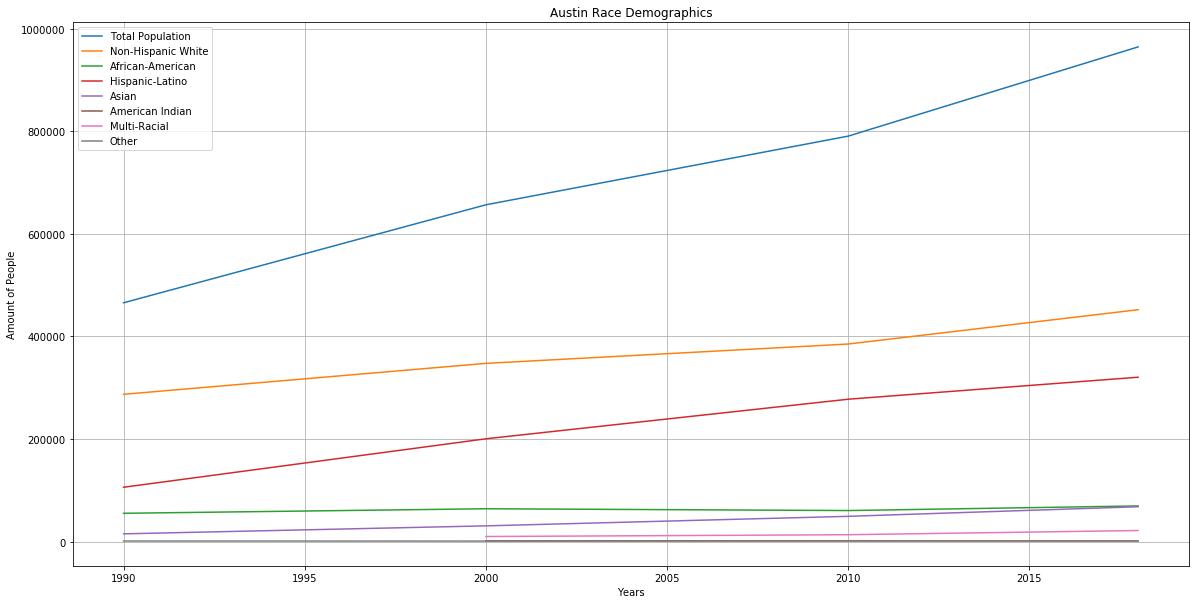

In [50]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Race Demographics")
plt.ylabel("Amount of People")
plt.xlabel("Years")
plt.grid()
plt.plot(race_demo)
plt.legend(labels = race_demo.columns)

# Save the figure
plt.savefig("RaceDemographics.png")

# Show plot
plt.show()

In [58]:
rg1 = growth(df["2000"][0:8],df["1990"][0:8]).tolist()
rg2 = growth(df["2010"][0:8],df["2000"][0:8]).tolist()
rg3 = growth(df["2018"][0:8],df["2010"][0:8]).tolist()
race_growth = pd.DataFrame([
    {"Year": 1990, demo[0]:0, demo[1]:0, demo[2]:0, demo[3]:0,
     demo[4]:0, demo[5]:0, demo[6]:0, demo[7]:0},
    {"Year": 2000,demo[0]:rg1[0], demo[1]:rg1[1], demo[2]:rg1[2], demo[3]:rg1[3],
     demo[4]:rg1[4], demo[5]:rg1[5], demo[6]:rg1[6], demo[7]:rg1[7]},
    {"Year": 2010,demo[0]:rg2[0], demo[1]:rg2[1], demo[2]:rg2[2], demo[3]:rg2[3],
     demo[4]:rg2[4], demo[5]:rg2[5], demo[6]:rg2[6], demo[7]:rg2[7]},
    {"Year": 2018,demo[0]:rg3[0], demo[1]:rg3[1], demo[2]:rg3[2], demo[3]:rg3[3],
     demo[4]:rg3[4], demo[5]:rg3[5], demo[6]:rg3[6], demo[7]:rg3[7]}
]).set_index("Year")
race_growth

,Total Population,Non-Hispanic White,African-American,Hispanic-Latino,Asian,American Indian,Multi-Racial,Other
Year,,,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,41.007513,20.977135,15.972134,88.936719,101.190941,NaN,NaN,-11.023622
2010,20.383147,10.852127,-5.445152,38.453677,60.135856,6.094930,34.642646,16.492357
2018,21.995850,17.348568,14.828835,15.430901,37.722700,-19.115404,59.735322,16.988950


In [59]:
race_growth = race_growth.apply(pd.to_numeric)

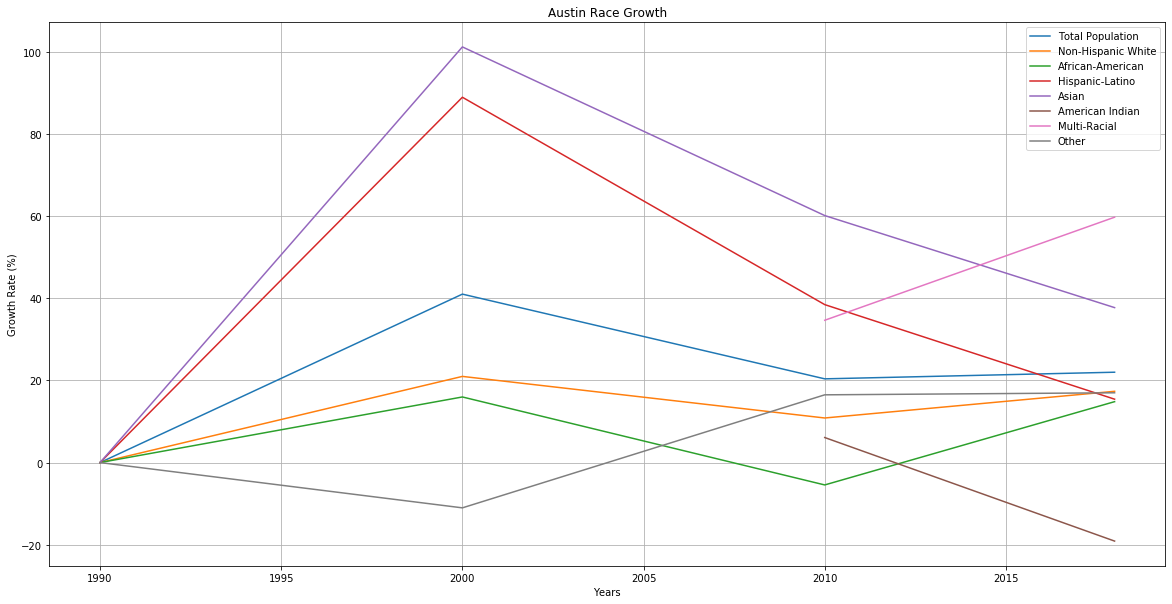

In [60]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Race Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid()
plt.plot(race_growth)
plt.legend(labels = race_growth.columns)

# Save the figure
plt.savefig("RaceGrowth.png")

# Show plot
plt.show()

## Age

In [8]:
def age(df):
    r = df["Data Item"][8:17].tolist()
    return r
def age_year1(df):
    y = df["1990"][8:17].tolist()
    return y
def age_year2(df):
    y = df["2000"][8:17].tolist()
    return y
def age_year3(df):
    y = df["2010"][8:17].tolist()
    return y
def age_year4(df):
    y = df["2018"][8:17].tolist()
    return y

In [69]:
demo2= age(df)
a1 = age_year1(df)
a2 = age_year2(df)
a3 = age_year3(df)
a4 = age_year4(df)
age_demo = pd.DataFrame([
    {"Year": 1990, demo2[0]:a1[0], demo2[1]:a1[1], demo2[2]:a1[2], demo2[3]:a1[3], demo2[4]:a1[4], 
     demo2[5]:a1[5], demo2[6]:a1[6], demo2[7]:a1[7]},
    {"Year": 2000, demo2[0]:a2[0], demo2[1]:a2[1], demo2[2]:a2[2], demo2[3]:a2[3], demo2[4]:a2[4],
     demo2[5]:a2[5], demo2[6]:a2[6], demo2[7]:a2[7]},
    {"Year": 2010, demo2[0]:a3[0], demo2[1]:a3[1], demo2[2]:a3[2], demo2[3]:a3[3], demo2[4]:a3[4], 
     demo2[5]:a3[5], demo2[6]:a3[6], demo2[7]:a3[7]},
    {"Year": 2018, demo2[0]:a4[0], demo2[1]:a4[1], demo2[2]:a4[2], demo2[3]:a4[3], demo2[4]:a4[4], 
     demo2[5]:a4[5], demo2[6]:a4[6], demo2[6]:a4[6], demo2[7]:a4[7]}
]).set_index("Year")
age_demo
# Values in Percent

,Under 5,5 to 17,18 to 24,25 to 34,35 to 44,45 to 54,55 to 64,Over 65
Year,,,,,,,,
1990,7.60,15.50,17.7,22.70,15.6,7.90,5.60,7.40
2000,7.10,15.40,16.6,21.10,16.0,11.60,5.60,6.70
2010,7.30,14.90,14.5,20.70,14.8,12.10,8.70,7.00
2018,6.27,13.46,10.4,22.74,15.6,11.87,10.34,9.36


In [10]:
median_age = pd.DataFrame([
    {"Year": 1990, demo2[8]:a1[8]},
    {"Year": 2000, demo2[8]:a2[8]},
    {"Year": 2010, demo2[8]:a3[8]},
    {"Year": 2018, demo2[8]:a4[8]}
]).set_index("Year")
median_age

,Median Age
Year,
1990,28.3
2000,29.6
2010,31.0
2018,32.0


In [11]:
age_demo = age_demo.apply(pd.to_numeric)
median_age = median_age.apply(pd.to_numeric)

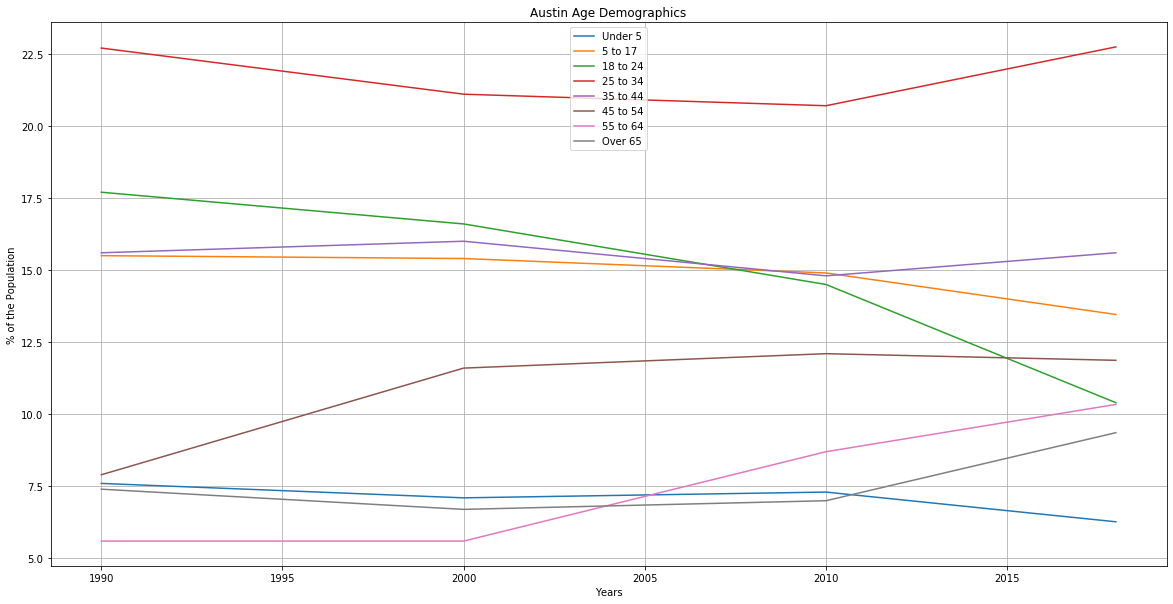

In [12]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Age Demographics")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid()
plt.plot(age_demo)
plt.legend(labels = age_demo.columns)

# Save the figure
plt.savefig("AgeDemographics.png")

# Show plot
plt.show()

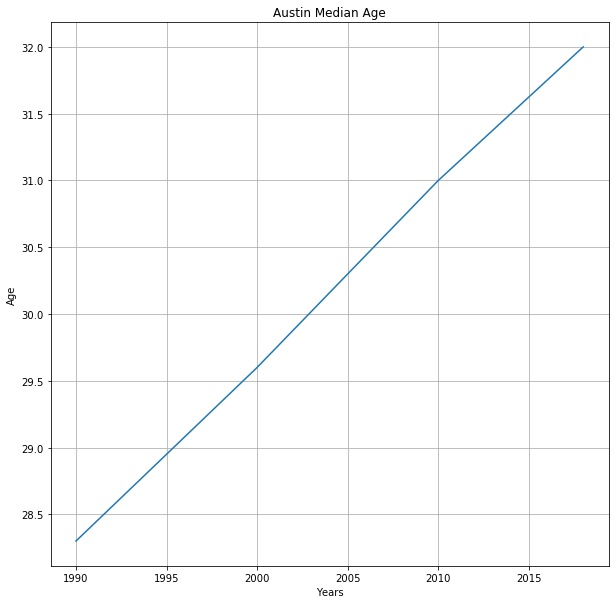

In [13]:
plt.figure(figsize=(10,10))


# Incorporate the other graph properties
plt.title("Austin Median Age")
plt.ylabel("Age")
plt.xlabel("Years")
plt.grid()
plt.plot(median_age)

# Save the figure
plt.savefig("MedianAge.png")

# Show plot
plt.show()

In [79]:
ac1 = percent_to_units1990(df["1990"][8:17]).tolist()
ac2 = percent_to_units2000(df["2000"][8:17]).tolist()
ac3 = percent_to_units2010(df["2010"][8:17]).tolist()
ac4 = percent_to_units2018(df["2018"][8:17]).tolist()
ag1 = growth(ac2[0:8],ac1[0:8]).tolist()
ag2 = growth(ac3[0:8],ac2[0:8]).tolist()
ag3 = growth(ac4[0:8],ac3[0:8]).tolist()
mag1 = growth(df["2000"][16],df["1990"][16])
mag2 = growth(df["2010"][16],df["2000"][16])
mag3 = growth(df["2018"][16],df["2010"][16])
age_growth = pd.DataFrame([
    {"Year": 1990, demo2[0]:0, demo2[1]:0, demo2[2]:0, demo2[3]:0, demo2[4]:0, 
     demo2[5]:0, demo2[6]:0, demo2[7]:0, demo2[8]:0},
    {"Year": 2000, demo2[0]:ag1[0], demo2[1]:ag1[1], demo2[2]:ag1[2], demo2[3]:ag1[3], demo2[4]:ag1[4],
     demo2[5]:ag1[5], demo2[6]:ag1[6], demo2[7]:ag1[7], demo2[8]:mag1},
    {"Year": 2010, demo2[0]:ag2[0], demo2[1]:ag2[1], demo2[2]:ag2[2], demo2[3]:ag2[3], demo2[4]:ag2[4], 
     demo2[5]:ag2[5], demo2[6]:ag2[6], demo2[7]:ag2[7], demo2[8]:mag2},
    {"Year": 2018, demo2[0]:ag3[0], demo2[1]:ag3[1], demo2[2]:ag3[2], demo2[3]:ag3[3], demo2[4]:ag3[4], 
     demo2[5]:ag3[5], demo2[6]:ag3[6], demo2[6]:ag3[6], demo2[7]:ag3[7], demo2[8]:mag3}
]).set_index("Year")
age_growth

,Under 5,5 to 17,18 to 24,25 to 34,35 to 44,45 to 54,55 to 64,Over 65,Median Age
Year,,,,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,31.730702,40.097787,32.244334,31.068657,44.623090,107.049006,41.007513,27.668964,4.593640
2010,23.774222,16.474604,5.153954,18.101002,11.354411,25.572076,87.023818,25.773438,4.729730
2018,4.782737,10.205647,-12.499528,34.018630,28.590220,19.676921,44.992769,63.125880,3.225806


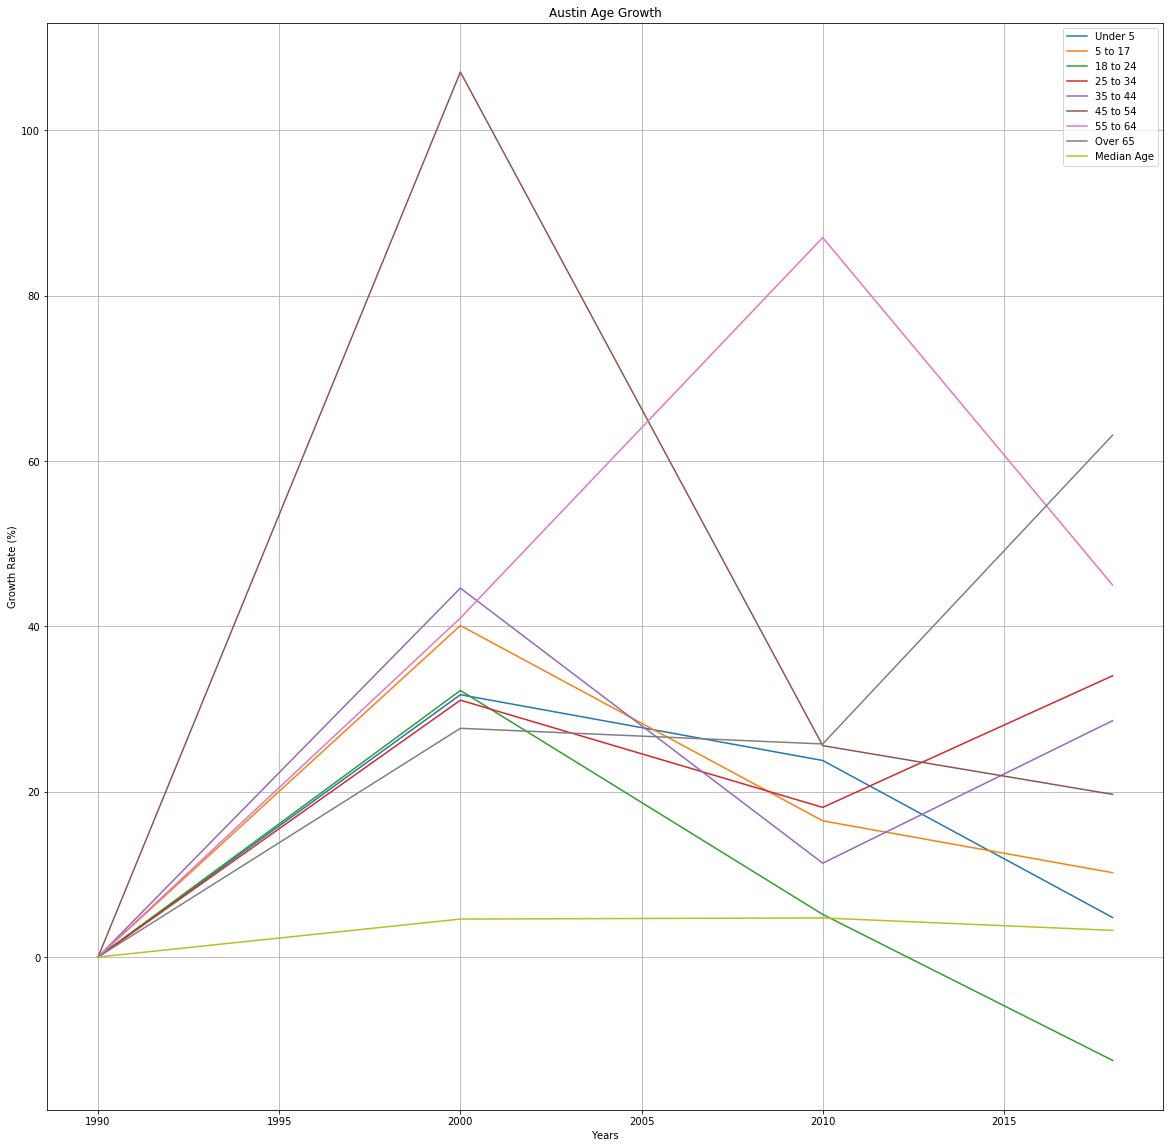

In [77]:
plt.figure(figsize=(20,20))


# Incorporate the other graph properties
plt.title("Austin Age Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid()
plt.plot(age_growth)
plt.legend(labels = age_growth.columns)

# Save the figure
plt.savefig("AgeGrowth.png")

# Show plot
plt.show()

## Sex

In [14]:
def sex(df):
    r = df["Data Item"][17:19].tolist()
    return r
def sex_year1(df):
    y = df["1990"][17:19].tolist()
    return y
def sex_year2(df):
    y = df["2000"][17:19].tolist()
    return y
def sex_year3(df):
    y = df["2010"][17:19].tolist()
    return y
def sex_year4(df):
    y = df["2018"][17:19].tolist()
    return y

In [15]:
demo3 = sex(df)
s1 = sex_year1(df)
s2 = sex_year2(df)
s3 = sex_year3(df)
s4 = sex_year4(df)
sex_demo = pd.DataFrame([
    {"Year": 1990, demo3[0]:s1[0], demo3[1]:s1[1]},
    {"Year": 2000,demo3[0]:s2[0], demo3[1]:s2[1]},
    {"Year": 2010,demo3[0]:s3[0], demo3[1]:s3[1]},
    {"Year": 2018,demo3[0]:s4[0], demo3[1]:s4[1]}
]).set_index("Year")
sex_demo

,Male,Female
Year,,
1990,49.93,50.07
2000,51.41,48.59
2010,50.57,49.43
2018,50.04,49.60


In [16]:
sex_demo = sex_demo.apply(pd.to_numeric)

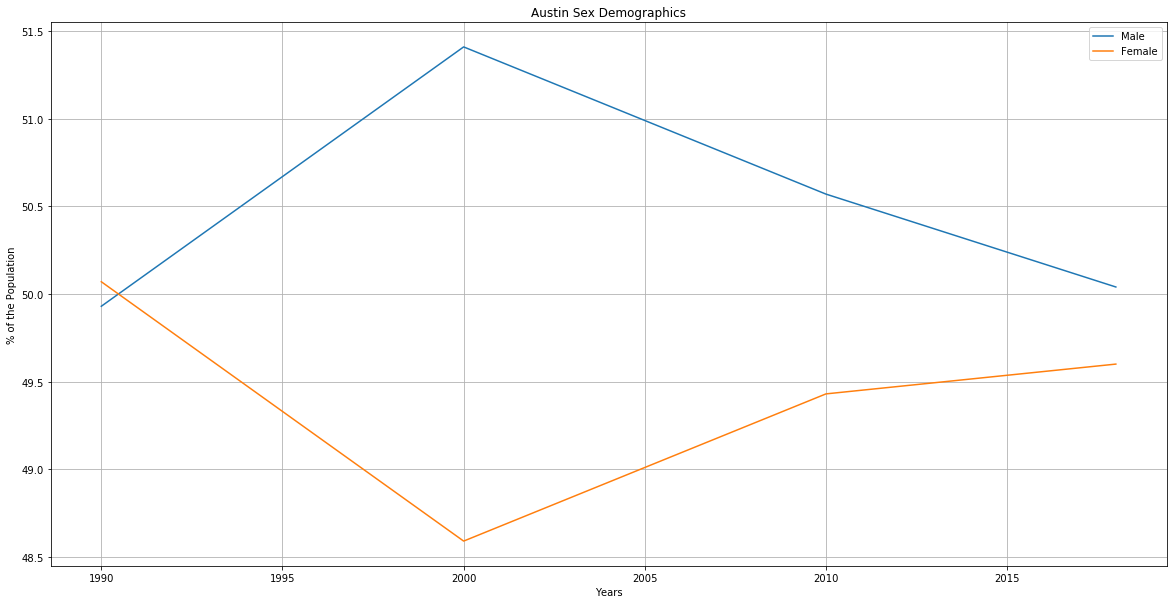

In [17]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Sex Demographics")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid()
plt.plot(sex_demo)
plt.legend(labels = sex_demo.columns)

# Save the figure
plt.savefig("SexDemographics.png")

# Show plot
plt.show()

In [80]:
sc1 = percent_to_units1990(df["1990"][17:19]).tolist()
sc2 = percent_to_units2000(df["2000"][17:19]).tolist()
sc3 = percent_to_units2010(df["2010"][17:19]).tolist()
sc4 = percent_to_units2018(df["2018"][17:19]).tolist()
sg1 = growth(sc2[0:2],sc1[0:2]).tolist()
sg2 = growth(sc3[0:2],sc2[0:2]).tolist()
sg3 = growth(sc4[0:2],sc3[0:2]).tolist()
sex_growth = pd.DataFrame([
    {"Year": 1990, demo3[0]:0, demo3[1]:0},
    {"Year": 2000,demo3[0]:sg1[0], demo3[1]:sg1[1]},
    {"Year": 2010,demo3[0]:sg2[0], demo3[1]:sg2[1]},
    {"Year": 2018,demo3[0]:sg3[0], demo3[1]:sg3[1]}
]).set_index("Year")
sex_growth

,Male,Female
Year,,
1990,0.000000,0.000000
2000,45.187186,36.839525
2010,18.416179,22.464272
2018,20.717270,22.415419


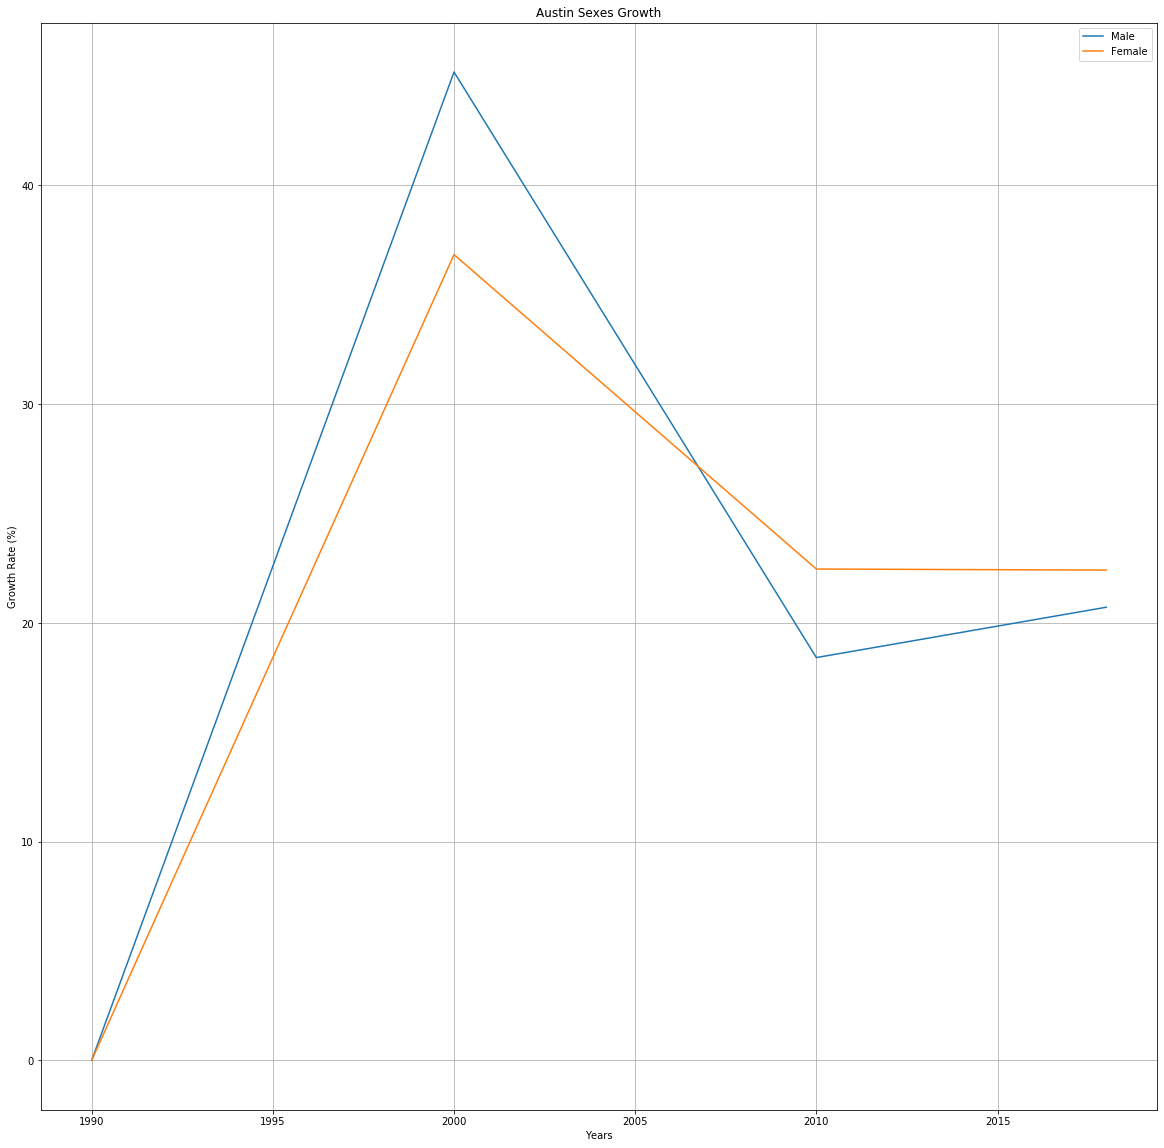

In [81]:
plt.figure(figsize=(20,20))


# Incorporate the other graph properties
plt.title("Austin Sexes Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid()
plt.plot(sex_growth)
plt.legend(labels = sex_growth.columns)

# Save the figure
plt.savefig("SexesGrowth.png")

# Show plot
plt.show()

## Social & Economics

In [21]:
def soci_econ(df):
    r = df["Data Item"][19:29].tolist()
    return r
def soec_year1(df):
    y = df["1990"][19:29].tolist()
    return y
def soec_year2(df):
    y = df["2000"][19:29].tolist()
    return y
def soec_year3(df):
    y = df["2010"][19:29].tolist()
    return y
def soec_year4(df):
    y = df["2018"][19:29].tolist()
    return y

In [31]:
units = soci_econ(df)
e1 = soec_year1(df)
e2 = soec_year2(df)
e3 = soec_year3(df)
e4 = soec_year4(df)
housing = pd.DataFrame([
    {"Year": 1990, units[0]:e1[0], units[1]:e1[1], units[2]:e1[2], units[9]:e1[9]},
    {"Year": 2000, units[0]:e2[0], units[1]:e2[1], units[2]:e2[2], units[9]:e2[9]},
    {"Year": 2010, units[0]:e3[0], units[1]:e3[1], units[2]:e3[2], units[9]:e3[9]},
    {"Year": 2018, units[0]:e4[0], units[1]:e4[1], units[2]:e4[2], units[9]:e4[9]}
]).set_index("Year")
housing

,Occupied Units,Owner Occupied,Renter Occupied,Family Households
Year,,,,
1990,217054.0,77974.0,114174.0,104791.0
2000,276842.0,119102.0,146547.0,141589.0
2010,354241.0,146666.0,178226.0,168582.0
2018,425076.0,175016.0,215379.0,214238.0


In [27]:
median_income = pd.DataFrame([
    {"Year": 1990, units[3]:e1[3]},
    {"Year": 2000, units[3]:e2[3]},
    {"Year": 2010, units[3]:e3[3]},
    {"Year": 2018, units[3]:e4[3]}
]).set_index("Year")
median_income

,Median Household Income(inflation adj.)
Year,
1990,43399.0
2000,54450.0
2010,50132.0
2018,71543.0


In [28]:
poverty = pd.DataFrame([
    {"Year": 1990, units[4]:e1[4], units[5]:e1[5]},
    {"Year": 2000, units[4]:e2[4], units[5]:e2[5]},
    {"Year": 2010, units[4]:e3[4], units[5]:e3[5]},
    {"Year": 2018, units[4]:e4[4], units[5]:e4[5]}
]).set_index("Year")
poverty

,Poverty Rate,Vacancy Rate
Year,,
1990,17.9,11.5
2000,14.4,4.0
2010,18.4,8.3
2018,13.3,8.2


In [30]:
education = pd.DataFrame([
    {"Year": 1990, units[7]:e1[7]},
    {"Year": 2000, units[7]:e2[7]},
    {"Year": 2010, units[7]:e3[7]},
    {"Year": 2018, units[7]:e4[7]}
]).set_index("Year")
education

,Bachelor's Degree or Higher
Year,
1990,34.4
2000,40.4
2010,43.9
2018,54.1


In [82]:
size = pd.DataFrame([
    {"Year": 1990, units[8]:e1[8]},
    {"Year": 2000, units[8]:e2[8]},
    {"Year": 2010, units[8]:e3[8]},
    {"Year": 2018, units[8]:e4[8]}
]).set_index("Year")
size

,Average Household Size
Year,
1990,2.33
2000,2.40
2010,2.37
2018,2.40


In [83]:
housing = housing.apply(pd.to_numeric)
median_income = median_income.apply(pd.to_numeric)
poverty = poverty.apply(pd.to_numeric)
education = education.apply(pd.to_numeric)
size = size.apply(pd.to_numeric)

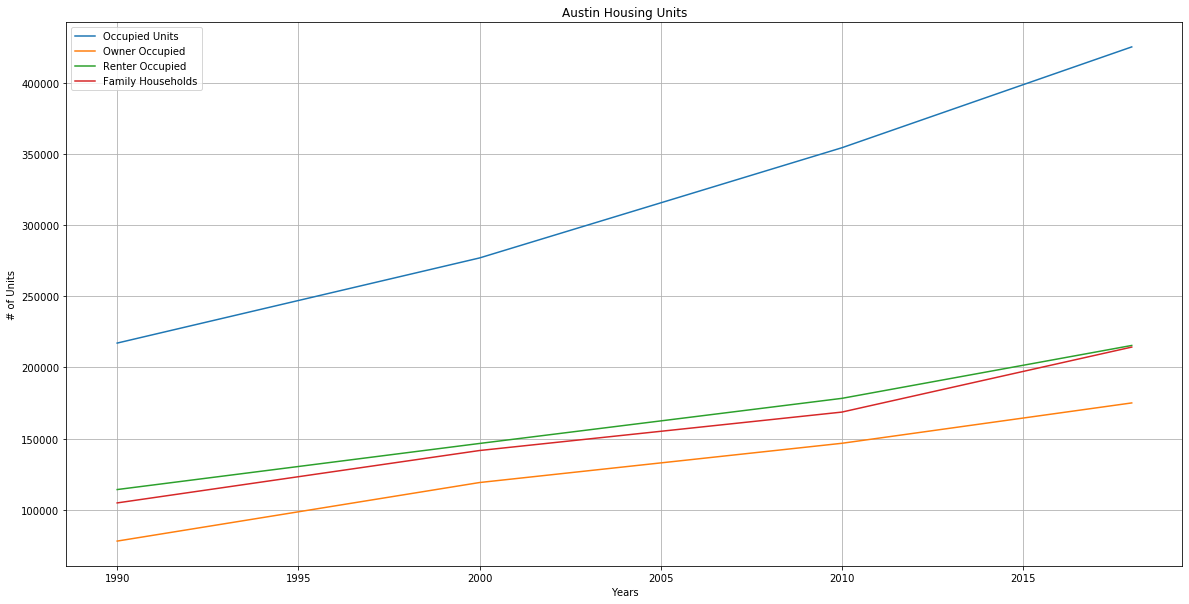

In [34]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Housing Units")
plt.ylabel("# of Units")
plt.xlabel("Years")
plt.grid()
plt.plot(housing)
plt.legend(labels = housing.columns)

# Save the figure
plt.savefig("HousingUnits.png")

# Show plot
plt.show()

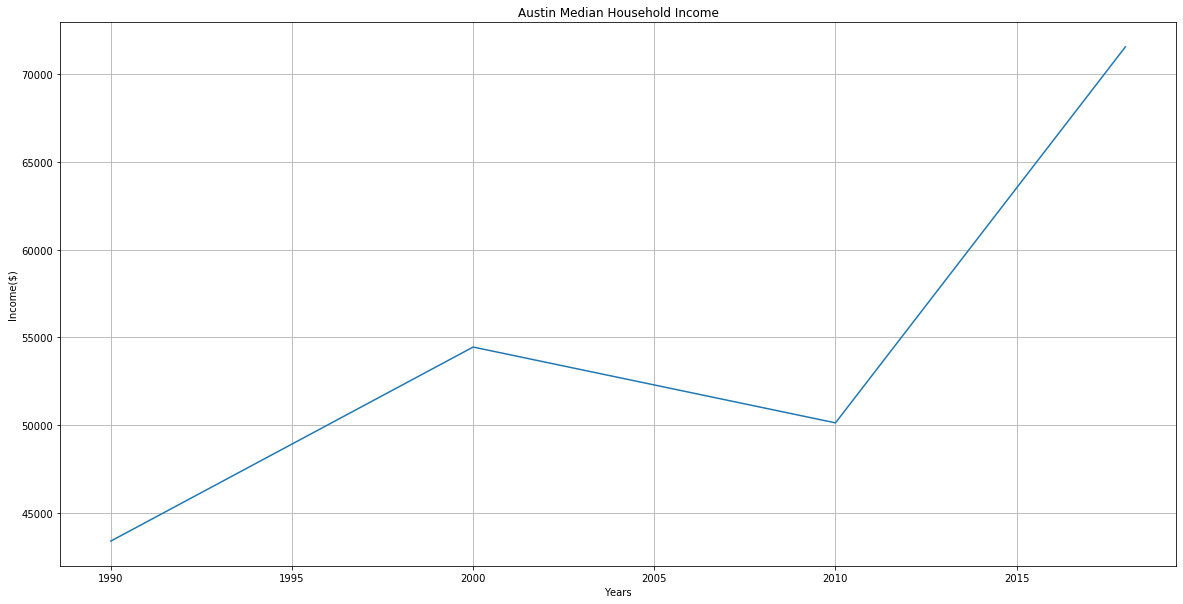

In [36]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Median Household Income")
plt.ylabel("Income($)")
plt.xlabel("Years")
plt.grid()
plt.plot(median_income)

# Save the figure
plt.savefig("MedianIncome.png")

# Show plot
plt.show()

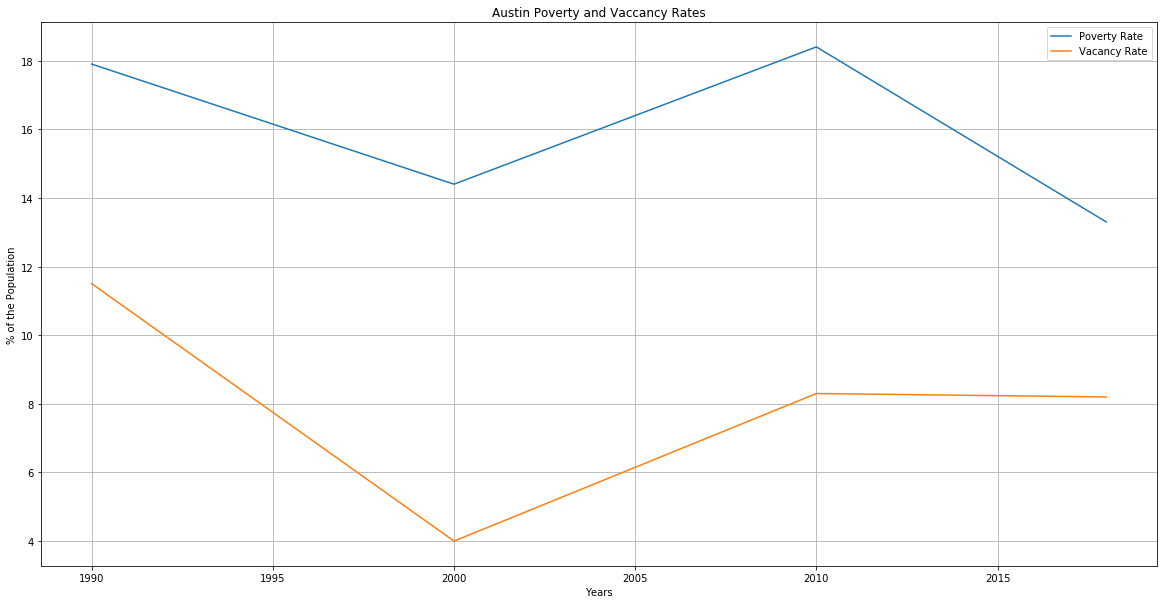

In [37]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Poverty and Vaccancy Rates")
plt.ylabel("% of the Population")
plt.xlabel("Years")
plt.grid()
plt.plot(poverty)
plt.legend(labels = poverty.columns)

# Save the figure
plt.savefig("PovertyVaccancy.png")

# Show plot
plt.show()

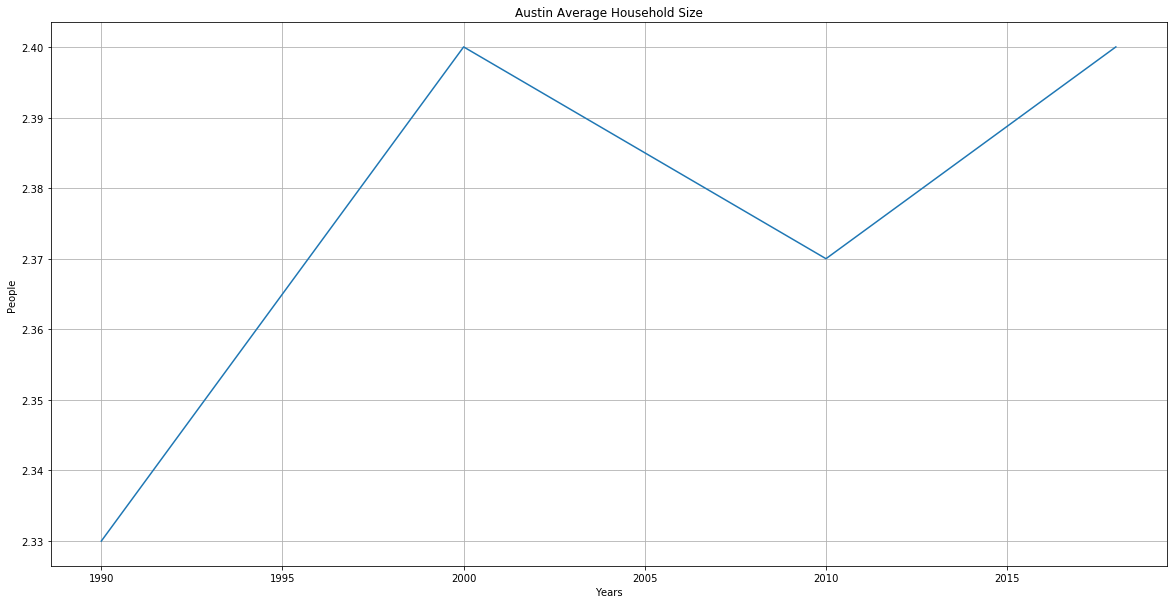

In [85]:
plt.figure(figsize=(20,10))


# Incorporate the other graph properties
plt.title("Austin Average Household Size")
plt.ylabel("People")
plt.xlabel("Years")
plt.grid()
plt.plot(size)

# Save the figure
plt.savefig("Size.png")

# Show plot
plt.show()

In [93]:
eg1 = growth(df["2000"][19:23],df["1990"][19:23]).tolist()
eg2 = growth(df["2010"][19:23],df["2000"][19:23]).tolist()
eg3 = growth(df["2018"][19:23],df["2010"][19:23]).tolist()
ec1 = percent_to_units1990(df["1990"][23:26]).tolist()
ec2 = percent_to_units2000(df["2000"][23:26]).tolist()
ec3 = percent_to_units2010(df["2010"][23:26]).tolist()
ec4 = percent_to_units2018(df["2018"][23:26]).tolist()
eg4 = growth(ec2[0:2],ec1[0:2]).tolist()
eg5 = growth(ec3[0:2],ec2[0:2]).tolist()
eg6 = growth(ec4[0:2],ec3[0:2]).tolist()
economic_growth = pd.DataFrame([
    {"Year": 1990, units[0]:0, units[1]:0, units[2]:0, units[3]:0, units[4]:0, units[5]:0},
    {"Year": 2000, units[0]:eg1[0], units[1]:eg1[1], units[2]:eg1[2], units[3]:eg1[3], units[4]:eg4[0], units[5]:eg4[1]},
    {"Year": 2010, units[0]:eg2[0], units[1]:eg2[1], units[2]:eg2[2], units[3]:eg2[3], units[4]:eg5[0], units[5]:eg5[1]},
    {"Year": 2018, units[0]:eg3[0], units[1]:eg3[1], units[2]:eg3[2], units[3]:eg3[3], units[4]:eg6[0], units[5]:eg6[1]}
]).set_index("Year")
economic_growth

,Occupied Units,Owner Occupied,Renter Occupied,Median Household Income(inflation adj.),Poverty Rate,Vacancy Rate
Year,,,,,,
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,27.545219,52.745787,28.354091,25.463720,13.436211,-50.953909
2010,27.957824,23.143188,21.616956,-7.930211,53.822911,149.795031
2018,19.996274,19.329633,20.846005,42.709248,-11.818217,20.526021


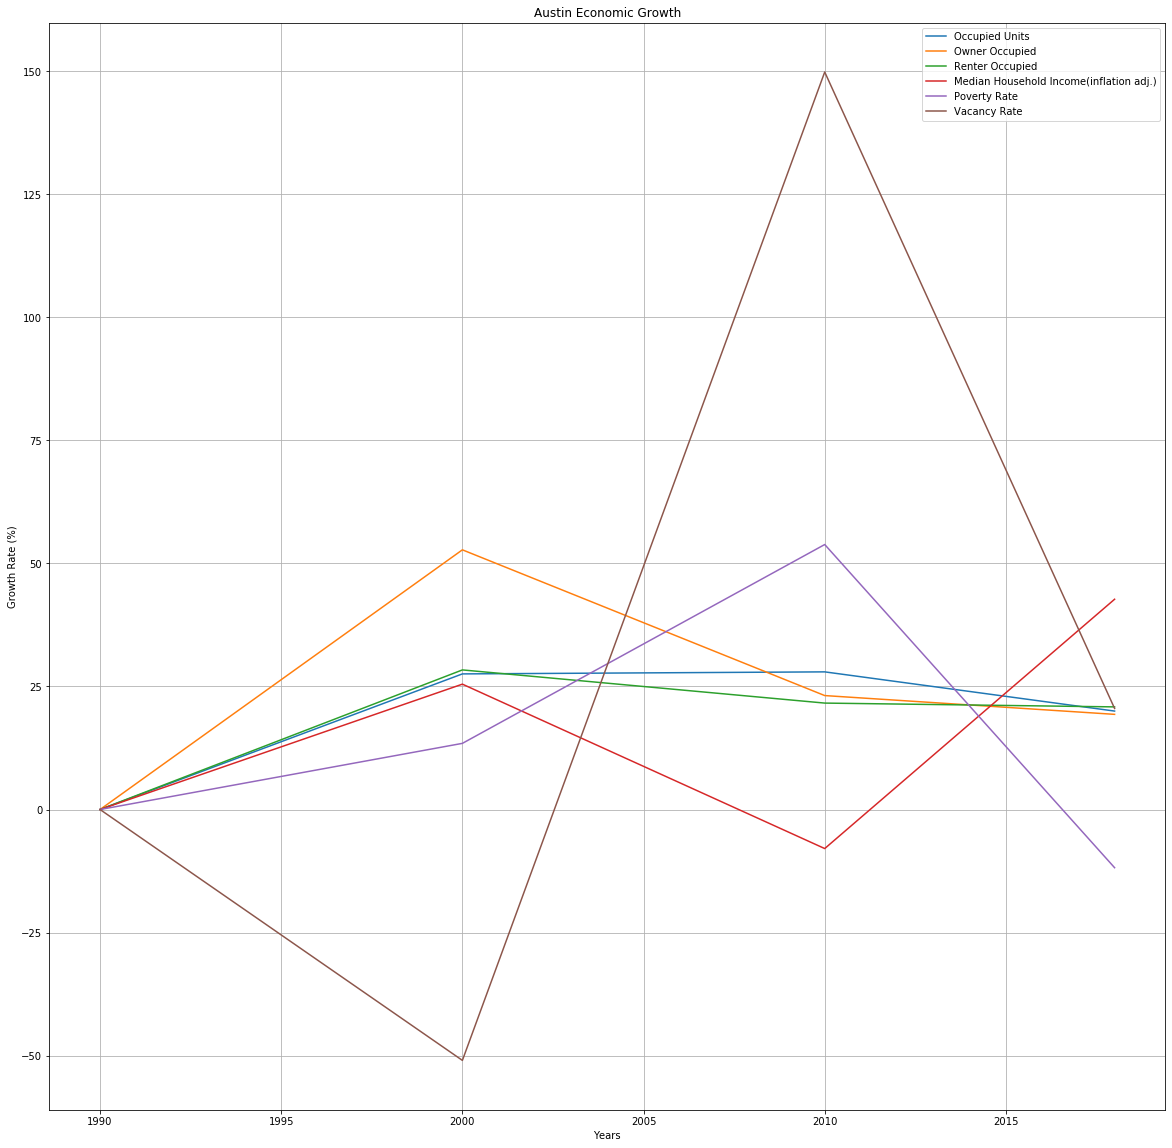

In [94]:
plt.figure(figsize=(20,20))


# Incorporate the other graph properties
plt.title("Austin Economic Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid()
plt.plot(economic_growth)
plt.legend(labels = economic_growth.columns)

# Save the figure
plt.savefig("EconomicGrowth.png")

# Show plot
plt.show()

In [99]:
sog1 = growth(df["2000"][27:29],df["1990"][27:29]).tolist()
sog2 = growth(df["2010"][27:29],df["2000"][27:29]).tolist()
sog3 = growth(df["2018"][27:29],df["2010"][27:29]).tolist()
soc1 = percent_to_units1990(df["1990"][26])
soc2 = percent_to_units2000(df["2000"][26])
soc3 = percent_to_units2010(df["2010"][26])
soc4 = percent_to_units2018(df["2018"][26])
sog4 = growth(soc2,soc1)
sog5 = growth(soc3,soc2)
sog6 = growth(soc4,soc3)
social_growth = pd.DataFrame([
    {"Year": 1990, units[7]:0, units[8]:0, units[9]:0},
    {"Year": 2000, units[8]:sog1[0], units[9]:sog1[1], units[7]:sog4},
    {"Year": 2010, units[8]:sog2[0], units[9]:sog2[1], units[7]:sog5},
    {"Year": 2018, units[8]:sog3[0], units[9]:sog3[1], units[7]:sog6}
]).set_index("Year")
social_growth

,Bachelor's Degree or Higher,Average Household Size,Family Households
Year,,,
1990,0.000000,0.000000,0.000000
2000,65.601846,3.004292,35.115611
2010,30.812380,-1.250000,19.064334
2018,50.341127,1.265823,27.082369


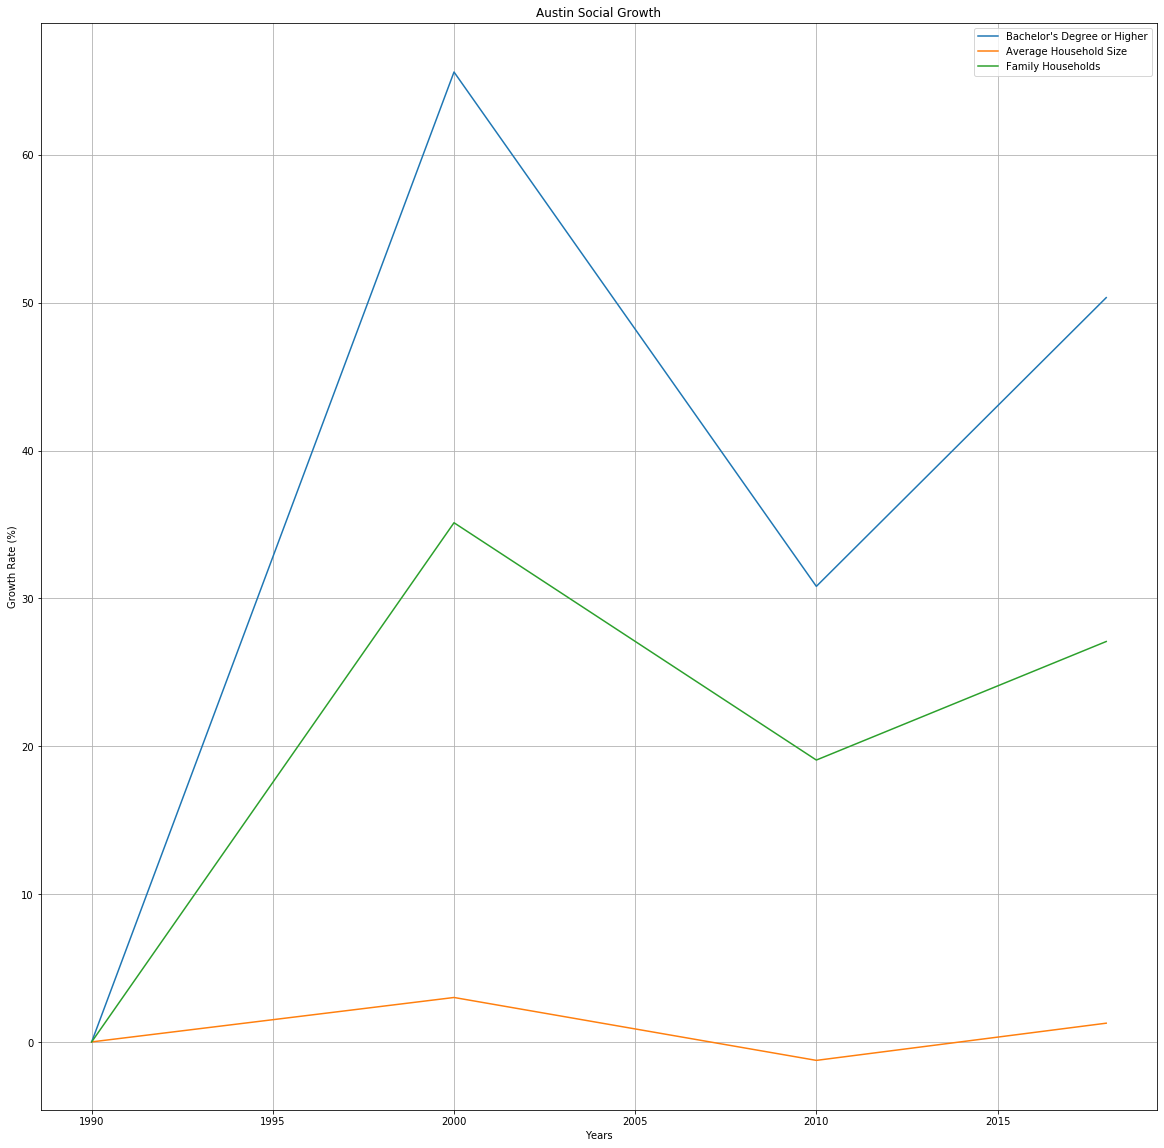

In [100]:
plt.figure(figsize=(20,20))


# Incorporate the other graph properties
plt.title("Austin Social Growth")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Years")
plt.grid()
plt.plot(social_growth)
plt.legend(labels = social_growth.columns)

# Save the figure
plt.savefig("SocialGrowth.png")

# Show plot
plt.show()